In [ ]:
import librosa
import librosa.display
import os
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data Audio

In [ ]:
def load_audio_files(folder_path):
    audio_files = []
    labels = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.endswith('.wav'):
            audio, sr = librosa.load(file_path, sr=None)
            audio_files.append(audio)
            labels.append(folder_path.split('/')[-1])
    return audio_files, labels

base_path = '/content/drive/My Drive/Dataset'
class_folders = ['left','right','stop','go','bed','bird','cat','dog','down','one','two','three','four','five','six','seven','eight','nine','zero','happy','house','marvin','no','off','on','sheila','tree','up','wow','yes']



all_audio_files = []
all_labels = []

for class_folder in class_folders:
    folder_path = os.path.join(base_path, class_folder)
    audio_files, labels = load_audio_files(folder_path)
    all_audio_files.extend(audio_files)
    all_labels.extend(labels)


Pembentukan Spektrogram dengan STFT

In [ ]:
n_fft = 512
hop_length = 128

def compute_spectrogram(audio):
    stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft_result)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    return log_spectrogram

spectrograms = [compute_spectrogram(audio) for audio in all_audio_files]


In [ ]:
def pad_or_crop_spectrogram(spectrogram, desired_shape):
    current_shape = spectrogram.shape
    if current_shape[1] < desired_shape[1]:
        pad_width = desired_shape[1] - current_shape[1]
        return np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    else:
        return spectrogram[:, :desired_shape[1]]

desired_shape = (257, 169)
spectrograms = [pad_or_crop_spectrogram(spec, desired_shape) for spec in spectrograms]


In [ ]:
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(all_labels)
one_hot_labels = to_categorical(numeric_labels)

Data splitting

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(spectrograms, one_hot_labels, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)


X_train = np.array(X_train)[..., np.newaxis]
X_val = np.array(X_val)[..., np.newaxis]
X_test = np.array(X_test)[..., np.newaxis]

Pembangunan model CNN

In [ ]:
num_class = len(np.unique(numeric_labels))

model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(257, 169, 1)))
model.add(keras.layers.MaxPooling2D((2, 3)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D((2, 3)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D((2, 3)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D((2, 3)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(num_class, activation=tf.nn.softmax))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/30
1213/1213 [==============================] - 88s 70ms/step - loss: 3.4974 - accuracy: 0.0383 - val_loss: 3.2993 - val_accuracy: 0.0813
Epoch 2/30
1213/1213 [==============================] - 79s 66ms/step - loss: 2.8237 - accuracy: 0.1746 - val_loss: 2.3908 - val_accuracy: 0.3708
Epoch 3/30
1213/1213 [==============================] - 82s 68ms/step - loss: 2.1371 - accuracy: 0.3602 - val_loss: 1.6793 - val_accuracy: 0.6031
Epoch 4/30
1213/1213 [==============================] - 81s 67ms/step - loss: 1.6769 - accuracy: 0.4929 - val_loss: 1.0945 - val_accuracy: 0.7131
Epoch 5/30
1213/1213 [==============================] - 80s 66ms/step - loss: 1.4283 - accuracy: 0.5712 - val_loss: 0.9457 - val_accuracy: 0.7523
Epoch 6/30
1213/1213 [==============================] - 80s 66ms/step - loss: 1.2865 - accuracy: 0.6143 - val_loss: 0.8469 - val_accuracy: 0.7847
Epoch 7/30
1213/1213 [==============================] - 84s 69ms/step - loss: 1.1733 - accuracy: 0.6511 - val_loss: 0.7856 -

Loss

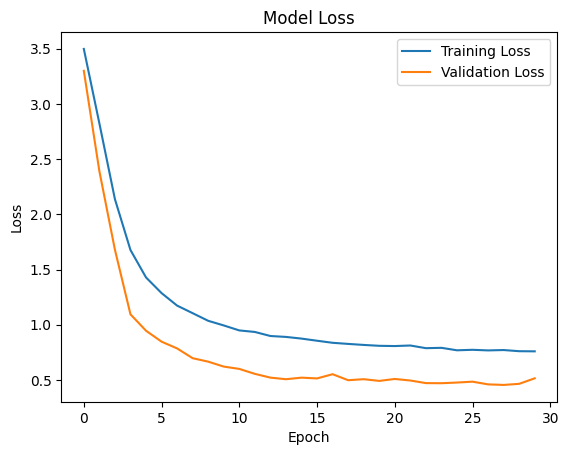

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)


Akurasi testing

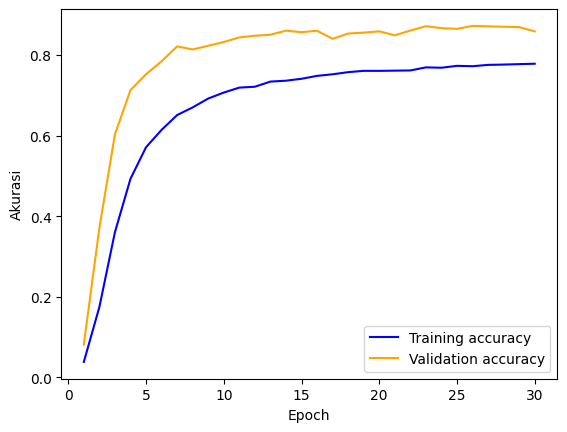

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
test_accuracy_percentage = test_accuracy * 100
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy_percentage:.2f}%')

405/405 [==============================] - 7s 18ms/step - loss: 0.5115 - accuracy: 0.8594
Test Loss: 0.5115
Test Accuracy: 85.94%


405/405 [==============================] - 7s 18ms/step


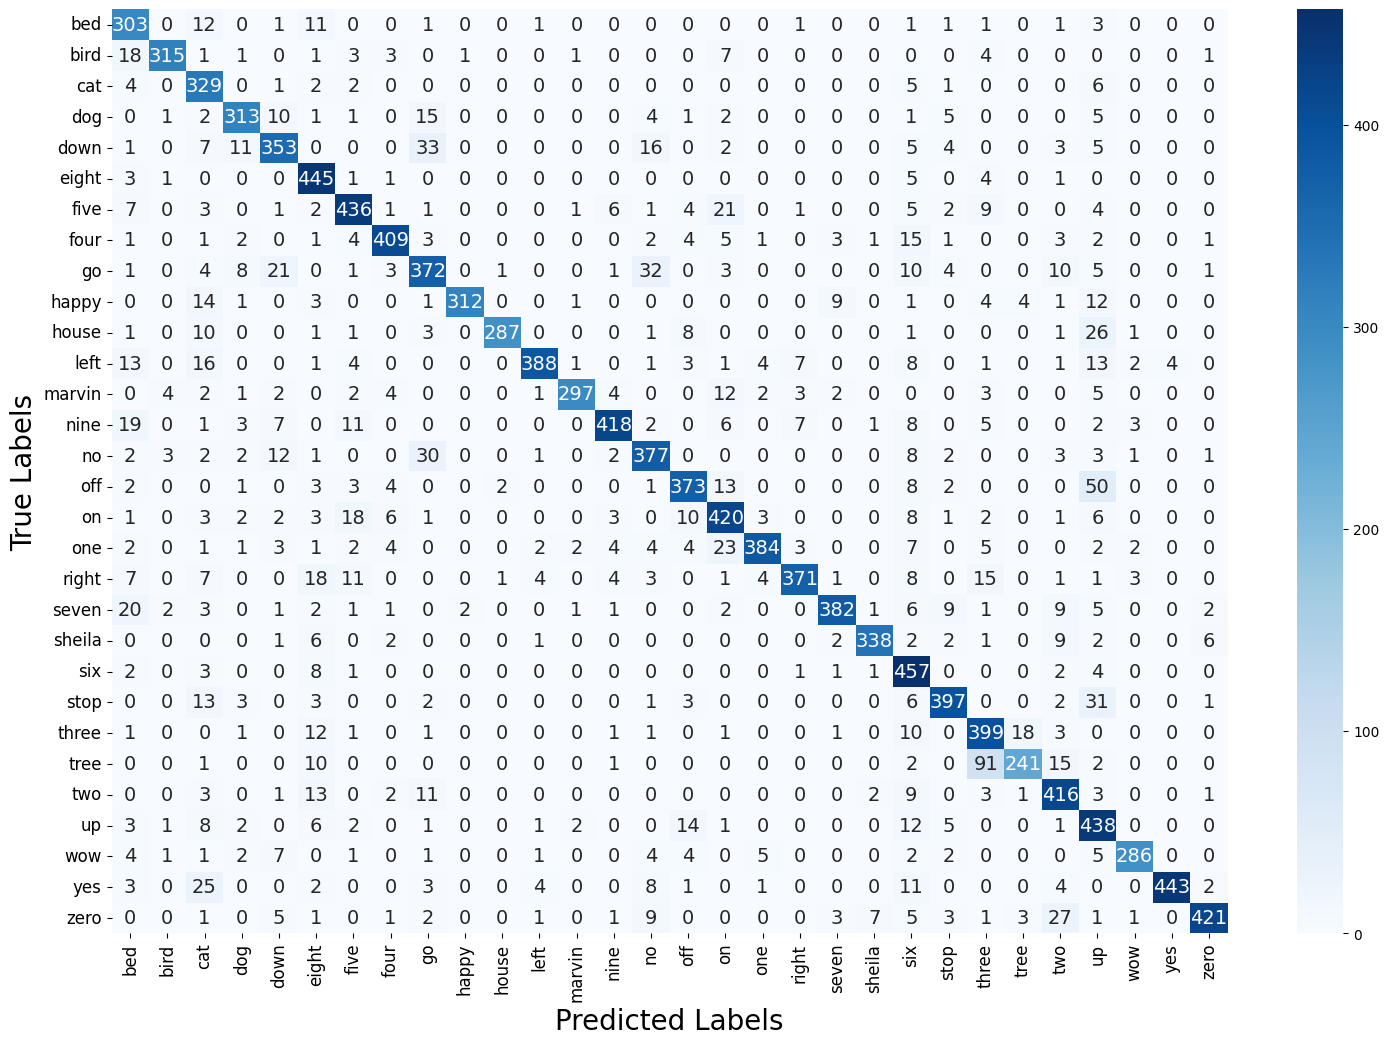

In [ ]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(18, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            annot_kws={"size": 14})
plt.xlabel('Predicted Labels', fontsize=20)
plt.ylabel('True Labels', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Prediksi dengan data baru

In [ ]:
def predict_audio(file_path, model, label_encoder):
    audio, sr = librosa.load(file_path, sr=None)
    log_spectrogram = compute_spectrogram(audio)
    log_spectrogram = pad_or_crop_spectrogram(log_spectrogram, desired_shape)
    log_spectrogram = log_spectrogram[..., np.newaxis]
    log_spectrogram = np.expand_dims(log_spectrogram, axis=0)
    prediction = model.predict(log_spectrogram)
    predicted_label = np.argmax(prediction)
    return label_encoder.inverse_transform([predicted_label])[0]

file_path = '/content/drive/My Drive/dataset_seminar/prediksi/go(2372).wav'
predicted_class = predict_audio(file_path, model, label_encoder)
print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 0s 30ms/step
The predicted class is: go


In [ ]:
def predict_audio(file_path, model, label_encoder):
    audio, sr = librosa.load(file_path, sr=None)
    log_spectrogram = compute_spectrogram(audio)
    log_spectrogram = pad_or_crop_spectrogram(log_spectrogram, desired_shape)
    log_spectrogram = log_spectrogram[..., np.newaxis]
    log_spectrogram = np.expand_dims(log_spectrogram, axis=0)
    prediction = model.predict(log_spectrogram)
    predicted_label = np.argmax(prediction)
    return label_encoder.inverse_transform([predicted_label])[0]

file_path = '/content/drive/My Drive/dataset_seminar/prediksi/left (2353).wav'
predicted_class = predict_audio(file_path, model, label_encoder)
print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 0s 29ms/step
The predicted class is: left


In [ ]:
def predict_audio(file_path, model, label_encoder):
    audio, sr = librosa.load(file_path, sr=None)
    log_spectrogram = compute_spectrogram(audio)
    log_spectrogram = pad_or_crop_spectrogram(log_spectrogram, desired_shape)
    log_spectrogram = log_spectrogram[..., np.newaxis]
    log_spectrogram = np.expand_dims(log_spectrogram, axis=0)
    prediction = model.predict(log_spectrogram)
    predicted_label = np.argmax(prediction)
    return label_encoder.inverse_transform([predicted_label])[0]

file_path = '/content/drive/My Drive/dataset_seminar/prediksi/right (2367).wav'
predicted_class = predict_audio(file_path, model, label_encoder)
print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 0s 28ms/step
The predicted class is: right


In [ ]:
def predict_audio(file_path, model, label_encoder):
    audio, sr = librosa.load(file_path, sr=None)
    log_spectrogram = compute_spectrogram(audio)
    log_spectrogram = pad_or_crop_spectrogram(log_spectrogram, desired_shape)
    log_spectrogram = log_spectrogram[..., np.newaxis]
    log_spectrogram = np.expand_dims(log_spectrogram, axis=0)
    prediction = model.predict(log_spectrogram)
    predicted_label = np.argmax(prediction)
    return label_encoder.inverse_transform([predicted_label])[0]

file_path = '/content/drive/My Drive/dataset_seminar/prediksi/stop (2380).wav'
predicted_class = predict_audio(file_path, model, label_encoder)
print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 0s 28ms/step
The predicted class is: stop
